In [1]:
from torch import nn

from transformers import BertTokenizer, BertForSequenceClassification

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
bert_model.classifier = nn.Linear(768, 3, bias=True)

from transformers import RobertaTokenizer, RobertaForSequenceClassification

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base')
roberta_model.classifier.out_proj = nn.Linear(768, 3, bias=True)

# from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

# tokenizer = GPT2Tokenizer.from_pretrained('microsoft/DialoGPT-medium')
# tokenizer.pad_token = tokenizer.eos_token
# model = GPT2ForSequenceClassification.from_pretrained('microsoft/DialoGPT-medium')
# # model
# model.score = nn.Linear(768, 3, bias=True)

# TweetBert
from transformers import AutoModel, AutoTokenizer, RobertaForSequenceClassification

bertweet_tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base',
                                          use_fast=False, normalization=True)
bertweet_model = RobertaForSequenceClassification.from_pretrained('vinai/bertweet-base')
bertweet_model.classifier.out_proj = nn.Linear(768, 3, bias=True)

# model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [2]:
import torch

bert_model = bert_model.to('cuda:2')
roberta_model = roberta_model.to('cuda:2')
bertweet_model = bertweet_model.to('cuda:3')

In [3]:
def get_texts(f_name='./twitter_sentiment', mode='train'):
    text_list = []
    label_list = []
    
    f_path = os.path.join(f_name, '{}.csv'.format(mode))
    with open(f_path) as f:
        reader = csv.DictReader(f)
        for line in reader:
            text_list.append(line['text'])
            if mode != 'test':
                label_list.append(int(line['sentiment_label']))

    return text_list, label_list

In [4]:
import os
import csv
import torch
from torch.utils.data import Dataset, DataLoader
class TwitterDataset(Dataset):
    def __init__(self, f_name='./twitter_sentiment', mode='train', tokenizer=None):
        self.mode = mode
        
        text_list, label_list = get_texts(f_name, mode)
        print('mode', mode, 'has', len(text_list), 'datas')
        text_list = tokenizer(text_list,
                             truncation=True, padding=True,
                             return_tensors='pt')

        self.text_list = text_list['input_ids']
        self.mask_list = text_list['attention_mask']
        self.label_list = label_list
    
    def __getitem__(self, idx):
        text = self.text_list[idx]
        mask = self.mask_list[idx]
        if self.mode == 'test':
            return text, mask
        label = torch.tensor(self.label_list[idx])
        return text, mask, label

    def __len__(self):
        return len(self.text_list)

In [5]:
criterion = nn.CrossEntropyLoss()

In [6]:
from tqdm import tqdm

def accuracy(raw_preds, y):
    preds = raw_preds.argmax(dim=1)
    acc = (preds == y).sum()
    return acc

def test(model, data, criterion, device):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)
        
        output = model(text, mask)
        pred = output.logits
        loss = criterion(pred, label)
        acc = accuracy(pred, label)
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

def predict(model, data, device):
    model.eval()
    
    preds = []
    for text, mask in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        
        output = model(text, mask)
        pred = output.logits
        preds.append(torch.argmax(pred, dim=1))
    preds = torch.cat(preds).cpu().tolist()
    return preds

In [7]:
import matplotlib.pyplot as plt

class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.train_acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []
    
    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_loss_list.append(train_loss)
        self.train_acc_list.append(train_acc)
        self.val_loss_list.append(val_loss)
        self.val_acc_list.append(val_acc)
    
    def plot(self):
        x = range(len(self.train_loss_list))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train_loss', 'val_loss'])
        plt.show()
        plt.plot(x, self.train_acc_list)
        plt.plot(x, self.val_acc_list, color='r')
        plt.legend(['train_acc', 'val_acc'])
        plt.show()

In [8]:
m = Meter()
all_preds = []

In [9]:
dataset_train = TwitterDataset(mode='train', tokenizer=bert_tokenizer)
dataset_val = TwitterDataset(mode='val', tokenizer=bert_tokenizer)
dataset_test = TwitterDataset(mode='test', tokenizer=bert_tokenizer)

batch_size = 64
train_data = DataLoader(dataset_train, batch_size=batch_size,
                       shuffle=True)
val_data = DataLoader(dataset_val, batch_size=batch_size // 2,
                       shuffle=False)
test_data = DataLoader(dataset_test, batch_size=batch_size // 2,
                       shuffle=False)

mode train has 10248 datas
mode val has 1464 datas
mode test has 2928 datas


In [10]:
f_ckpts = ['bert_best.pt']
device = torch.device('cuda:2')

for f in f_ckpts:
    ckpt = torch.load(f)
    bert_model.load_state_dict(ckpt)
    
    train_loss, train_acc = test(bert_model, train_data, criterion, device=device)
    val_loss, val_acc = test(bert_model, val_data, criterion, device=device)
    m.update(train_loss, train_acc, val_loss, val_acc)
    print('file:', f)
    print('train loss:', train_loss, 'train_acc', train_acc)
    print('val loss:', val_loss, 'val_acc', val_acc)

100%|██████████| 46/46 [00:01<00:00, 26.02it/s]

file: bert_best.pt
train loss: 0.0030178070318456927 train_acc 0.9392076502732241
val loss: 0.013959414106819147 val_acc 0.8490437158469946


In [11]:
f_ckpts = ['bert_best.pt']
device = torch.device('cuda:2')

for f in f_ckpts:
    ckpt = torch.load(f)
    bert_model.load_state_dict(ckpt)

    preds = predict(bert_model, test_data, device=device)
    all_preds.append(preds)

100%|██████████| 92/92 [00:04<00:00, 22.91it/s]


In [12]:
dataset_train = TwitterDataset(mode='train', tokenizer=roberta_tokenizer)
dataset_val = TwitterDataset(mode='val', tokenizer=roberta_tokenizer)
dataset_test = TwitterDataset(mode='test', tokenizer=roberta_tokenizer)

batch_size = 32
train_data = DataLoader(dataset_train, batch_size=batch_size,
                       shuffle=True)
val_data = DataLoader(dataset_val, batch_size=batch_size // 2,
                       shuffle=False)
test_data = DataLoader(dataset_test, batch_size=batch_size // 2,
                       shuffle=False)

mode train has 10248 datas
mode val has 1464 datas
mode test has 2928 datas


In [13]:
f_ckpts = ['roberta_m1.pt', 'roberta_m3.pt']
device = torch.device('cuda:2')

for f in f_ckpts:
    ckpt = torch.load(f)
    roberta_model.load_state_dict(ckpt)
    
    train_loss, train_acc = test(roberta_model, train_data, criterion, device=device)
    val_loss, val_acc = test(roberta_model, val_data, criterion, device=device)
    m.update(train_loss, train_acc, val_loss, val_acc)
    print('file:', f)
    print('train loss:', train_loss, 'train_acc', train_acc)
    print('val loss:', val_loss, 'val_acc', val_acc)

100%|██████████| 92/92 [00:02<00:00, 38.84it/s]


file: roberta_m1.pt
train loss: 0.00526285382801235 train_acc 0.944184231069477
val loss: 0.02806949893984679 val_acc 0.8558743169398907


100%|██████████| 92/92 [00:02<00:00, 42.69it/s]

file: roberta_m3.pt
train loss: 0.0035503628410349522 train_acc 0.9666276346604216
val loss: 0.027962825586764866 val_acc 0.8633879781420765


In [14]:
f_ckpts = ['roberta_m1.pt', 'roberta_m3.pt']
device = torch.device('cuda:2')

for f in f_ckpts:
    ckpt = torch.load(f)
    roberta_model.load_state_dict(ckpt)
    
    preds = predict(roberta_model, test_data, device=device)
    all_preds.append(preds)

100%|██████████| 183/183 [00:04<00:00, 42.24it/s]


In [15]:
dataset_train = TwitterDataset(mode='train', tokenizer=bertweet_tokenizer)
dataset_val = TwitterDataset(mode='val', tokenizer=bertweet_tokenizer)
dataset_test = TwitterDataset(mode='test', tokenizer=bertweet_tokenizer)

batch_size = 32
train_data = DataLoader(dataset_train, batch_size=batch_size,
                       shuffle=True)
val_data = DataLoader(dataset_val, batch_size=batch_size // 2,
                       shuffle=False)
test_data = DataLoader(dataset_test, batch_size=batch_size // 2,
                       shuffle=False)

mode train has 10248 datas
mode val has 1464 datas
mode test has 2928 datas


In [16]:
f_ckpts = ['bertweet_m1.pt', 'bertweet_m2.pt', 'bertweet_m3.pt', 'bertweet_m4.pt']
device = torch.device('cuda:3')

for f in f_ckpts:
    ckpt = torch.load(f)
    bertweet_model.load_state_dict(ckpt)
    
    train_loss, train_acc = test(bertweet_model, train_data, criterion, device=device)
    val_loss, val_acc = test(bertweet_model, val_data, criterion, device=device)
    m.update(train_loss, train_acc, val_loss, val_acc)
    print('file:', f)
    print('train loss:', train_loss, 'train_acc', train_acc)
    print('val loss:', val_loss, 'val_acc', val_acc)

100%|██████████| 92/92 [00:02<00:00, 40.98it/s]


file: bertweet_m1.pt
train loss: 0.0021247976835527013 train_acc 0.9838992974238876
val loss: 0.03320244217260939 val_acc 0.8510928961748634


100%|██████████| 92/92 [00:02<00:00, 40.21it/s]


file: bertweet_m2.pt
train loss: 0.0023855631503078047 train_acc 0.9810694769711163
val loss: 0.030525195192866273 val_acc 0.8633879781420765


100%|██████████| 92/92 [00:02<00:00, 41.02it/s]


file: bertweet_m3.pt
train loss: 0.002508081782029056 train_acc 0.980191256830601
val loss: 0.03046279139829484 val_acc 0.8681693989071039


100%|██████████| 92/92 [00:02<00:00, 36.08it/s]

file: bertweet_m4.pt
train loss: 0.002522332678133859 train_acc 0.9784348165495707
val loss: 0.028642687131014595 val_acc 0.8715846994535519


In [17]:
f_ckpts = ['bertweet_m1.pt', 'bertweet_m2.pt', 'bertweet_m3.pt', 'bertweet_m4.pt']
device = torch.device('cuda:3')

for f in f_ckpts:
    ckpt = torch.load(f)
    bertweet_model.load_state_dict(ckpt)
    
    preds = predict(bertweet_model, test_data, device=device)
    all_preds.append(preds)

100%|██████████| 183/183 [00:04<00:00, 40.27it/s]


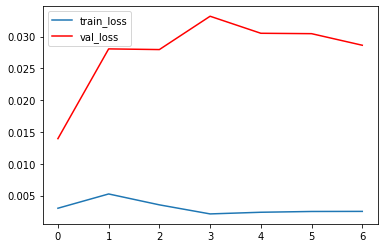

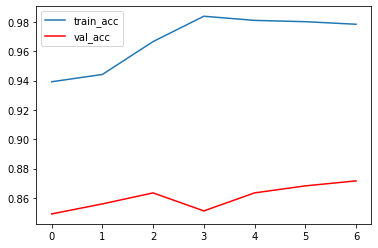

In [18]:
m.plot()

In [19]:
pp = torch.tensor(all_preds)
pp.shape

torch.Size([7, 2928])

In [20]:
final_preds = []
for ii in range(pp.shape[1]):
    p = pp[:, ii].tolist()
#     print(p, end=' ')
    
    d = dict()
    for temp in p:
        if temp in d:
            d[temp] += 1
        else:
            d[temp] = 0
    
    max_k = list(d.keys())[0]
    for k, v in d.items():
        if v > d[max_k]:
            max_k = k
#     print(max_k)
    
    final_preds.append(max_k)

In [21]:
with open('pred.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(final_preds):
        f.write('{},{}\n'.format(i, pred))